## Topic Modeling for group of twitter users

In [1]:
import nltk
nltk.download('stopwords')
import re
import numpy as np
import pandas as pd
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from gensim import matutils, models
import scipy.sparse
from collections import defaultdict
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import gensim
from sklearn.feature_extraction import text
import warnings
warnings.filterwarnings('ignore')
nltk.download('punkt')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
# spacy for lemmatization
import spacy
import matplotlib.pyplot as  plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [5]:
data1= pd.read_csv("new_datasets/airline_tweets_2016.csv")
tweet_df=pd.DataFrame(data1)
tweet_df.head(5)

,user_id,user_name,tweet_id,tweet,date,total_tweet_count,retweet_count,favorite_count
0,271675515,Saif,726435442858573824,Want to send me a DM? Just ask,2016-04-30 15:38:00,11,0,5
1,7693,tony,711060034667479040,SF residents can sign up for 100% renewable po...,2016-03-19 05:21:37,127,0,1
2,790038,kamal,736952199813599233,@aazraai nope,2016-05-29 16:07:51,25329,0,0
3,790038,kamal,735848321881759744,@wr Al gore,2016-05-26 15:01:25,25329,0,0
4,790038,kamal,735283525256024065,For context https://t.co/mLOJR8PgB3 https://t....,2016-05-25 01:37:07,25329,3,2


In [6]:
#Make single doc for each user
df = tweet_df.groupby('user_id')['tweet'].apply(' '.join).reset_index()
df = pd.merge(df,tweet_df[['user_id','user_name']],on='user_id',how='left')
df = df.drop_duplicates(subset=['user_id'], keep='first')

In [7]:
#Tokenization, stop word removal, punctuation and lematization
def preprocess(df):
    #Convert to lowercase
    text = df.lower()
   
    text = re.sub(r'http\S+', '', text) # remove http links
    text = re.sub(r'bit.ly/\S+', '', text) # rempve bitly links
    text = text.strip('[link]') # remove [links]
    
    text = re.sub('(rt\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', text) # remove retweet
    text = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', text) # remove tweeted at
    #Remove punctuation
    text = re.sub(r'[^\w\s]','',text)
    
    #Remove numbers
    text = re.sub("\d+", "", text)
    
    #Seperate/ Tokenize sentence
    words = word_tokenize(text)
    
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words] 

    #Remove the stopwords
    sw = stopwords.words('english')

    # Re-add the additional stop words since we are recreating the document-term matrix
    add_stop_words = ['like','via','know','get','just','use', 'make','made','dont', 'that', 'right','well', 'look', 'see','way',
                  'your', 'would','got','gonna','let', 'take', 'time', 'think', 'yeah', 'said', 'peopl', 'new', 'sinc','thank','day','year',
                  'one','say','want','thing','need','work','great','today','thi','whi','good','come','never','come','alway','also','feel','ever',
                  'first','veri','sorri','someth','because','ive','first','much','still','tri','cant','back','could',
                     'even','mani','last','better','watch','give','show','didnt','wait','cool','start','find','nice','long',
                     'real']
    
    #add_stop_words = ['like','via','know','get','just','use', 'make','made','dont', 'that', 'right','well', 'look', 'see','way',
                  #'your', 'would','got','gonna','let', 'take', 'time', 'think', 'yeah', 'said', 'peopl', 'new', 'sinc','thank','day','year',
                  #'one','say','want','thing','need','work','great','today','thi','whi','good','come','never','come','alway','also','feel','ever',
                  #'first','veri','sorri','someth','because','ive','first','much','still','tri','cant','back','could',
                     #'even','mani','last','better','watch','give','show','didnt','wait','cool','start','find','nice','long',
                     #'real']
    
    for i in add_stop_words:
        sw.append(i)
    words = [word for word in words if word not in sw]

    nltk_words = set(nltk.corpus.words.words())
    words = [word for word in words if word.lower() in nltk_words or not word.isalpha()]
     
    words = [w for w in words if len(w) > 3]

    return(words)

df['tokens'] = df['tweet'].apply(preprocess)
df.head(5)

,user_id,tweet,user_name,tokens
0,20,“Designing the worst place to be poor” by @Ale...,ev,"[design, worst, place, poor, disrupt, slow, co..."
47,60,RT @SLMPD: Today we remember those who sacrifi...,andrew,"[live, freedom, everyday, attend, game, nation..."
102,5488,20min FTP test after work today. Looking forwa...,daniel,"[test, forward, lucid, chart, sure, though, ki..."
134,5943,Let’s go Warriors! #WarriorsGround https://t.c...,brian,"[warrior, nitwit, brilliant, peter, tonight, v..."
262,7693,SF residents can sign up for 100% renewable po...,tony,"[sign, renew, power, power]"


In [10]:
from nltk import WordNetLemmatizer
def lemma_pos(text):    
    words=[]
    nouns_adj = []
    tagged_text = nltk.pos_tag(text)
    #print(tagged_text)\
    for word, tag in tagged_text:
        words.append({"word": word, "pos": tag})
        nouns_adj = []
        lem = WordNetLemmatizer()   
        for word in words:
            if word["pos"] in ["NN","NNS","NNP","NNPS","ADJ","JJ","JJR","JJS"]:
                nouns_adj.append(lem.lemmatize(word["word"]))
        nouns_adj = nouns_adj
    return(nouns_adj)
        

In [13]:
df['lemma_post'] = df['tokens'].apply(lemma_pos)

In [14]:
df['clean_text'] = df['lemma_post'].apply(' '.join)
df

,user_id,tweet,user_name,tokens,lemma_post,clean_text
0,20,“Designing the worst place to be poor” by @Ale...,ev,"[design, worst, place, poor, disrupt, slow, co...","[design, worst, place, poor, disrupt, slow, co...",design worst place poor disrupt slow complex j...
47,60,RT @SLMPD: Today we remember those who sacrifi...,andrew,"[live, freedom, everyday, attend, game, nation...","[live, freedom, everyday, attend, game, nation...",live freedom everyday attend game nation weeke...
102,5488,20min FTP test after work today. Looking forwa...,daniel,"[test, forward, lucid, chart, sure, though, ki...","[test, chart, sure, kick, doubt, save, oversea...",test chart sure kick doubt save oversea trip p...
134,5943,Let’s go Warriors! #WarriorsGround https://t.c...,brian,"[warrior, nitwit, brilliant, peter, tonight, v...","[warrior, nitwit, brilliant, peter, best, seas...",warrior nitwit brilliant peter best season twe...
262,7693,SF residents can sign up for 100% renewable po...,tony,"[sign, renew, power, power]","[sign, power, power]",sign power power
263,10738,Linear algebra for game developers ~ part 1 - ...,fabricio,"[algebra, game, develop, part, game, site, per...","[algebra, game, part, game, site, permit, geni...",algebra game part game site permit genial limi...
295,677083,"@tvldiva she grew up in England, moved to US w...",sherlock,"[grew, move, older, live, career]","[move, live, career]",move live career
296,681233,RT @SoftwareSaved: First ever conference of Re...,Cornelia,"[research, call, world, technologist, help, sp...","[research, call, world, technologist, help, wo...",research call world technologist help word div...
331,760798,Up in the hill @ Fracc El Lago https://t.co/Cx...,gabo,"[hill, amor, cantina, cantina, stage, poco, pa...","[hill, cantina, cantina, stage, poco, para, ma...",hill cantina cantina stage poco para maestro p...
448,784560,RT @sarahjeong: 🚨 GOOGLE'S USE OF THE DECLARIN...,kev,"[code, fair]","[code, fair]",code fair


In [15]:
df.to_csv('new_datasets/cleaned_lemma_data_airlines.csv')

In [16]:
from gensim import corpora

text_list = [i.split() for i in df.clean_text]
dictionary = corpora.Dictionary(text_list)
dictionary.save('dictionary.dict')

doc_term_matrix = [dictionary.doc2bow(doc) for doc in text_list]
corpora.MmCorpus.serialize('corpus.mm', doc_term_matrix)

In [19]:
mallet_path = '/mnt/c/Users/shaky/Documents/mallet-2.0.8/bin/mallet' 

In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [33]:
# Can take a long time to run.
from gensim.models import CoherenceModel
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=df['lemma_post'], start=2, limit=40, step=3)

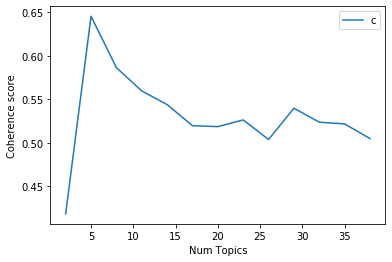

In [34]:
limit=40; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [35]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 3))

Num Topics = 2  has Coherence Value of 0.418
Num Topics = 5  has Coherence Value of 0.646
Num Topics = 8  has Coherence Value of 0.586
Num Topics = 11  has Coherence Value of 0.56
Num Topics = 14  has Coherence Value of 0.544
Num Topics = 17  has Coherence Value of 0.52
Num Topics = 20  has Coherence Value of 0.519
Num Topics = 23  has Coherence Value of 0.526
Num Topics = 26  has Coherence Value of 0.504
Num Topics = 29  has Coherence Value of 0.54
Num Topics = 32  has Coherence Value of 0.524
Num Topics = 35  has Coherence Value of 0.522
Num Topics = 38  has Coherence Value of 0.505


In [36]:
# Select the model and print the topics
from pprint import pprint
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=20))

[(0,
  '0.064*"stock" + 0.056*"symbol" + 0.051*"pick" + 0.038*"order" + '
  '0.036*"alert" + 0.035*"news" + 0.035*"ticker" + 0.022*"money" + '
  '0.020*"market" + 0.019*"share" + 0.017*"bell" + 0.016*"week" + '
  '0.016*"bullish" + 0.015*"success" + 0.015*"para" + 0.014*"rate" + '
  '0.014*"analyst" + 0.013*"yahoo" + 0.013*"float" + 0.013*"true"'),
 (1,
  '0.033*"latest" + 0.033*"news" + 0.029*"truck" + 0.028*"interview" + '
  '0.024*"ship" + 0.019*"risk" + 0.013*"port" + 0.012*"pour" + 0.011*"chain" + '
  '0.010*"strike" + 0.010*"cost" + 0.009*"transport" + 0.009*"drone" + '
  '0.008*"food" + 0.008*"global" + 0.008*"target" + 0.008*"steel" + '
  '0.007*"plan" + 0.007*"china" + 0.007*"rule"'),
 (2,
  '0.016*"love" + 0.015*"world" + 0.010*"trump" + 0.009*"live" + 0.009*"game" '
  '+ 0.009*"talk" + 0.008*"tweet" + 0.008*"friend" + 0.008*"chateau" + '
  '0.007*"version" + 0.007*"morn" + 0.007*"sport" + 0.006*"power" + '
  '0.006*"point" + 0.006*"share" + 0.006*"book" + 0.006*"post" + 0.00

In [37]:
optimal_model.save('ldamallet.gensim')

In [38]:
import pyLDAvis.gensim
import gensim
pyLDAvis.enable_notebook()
d = gensim.corpora.Dictionary.load('dictionary.dict')
c = gensim.corpora.MmCorpus('corpus.mm')
lda_mallet = gensim.models.wrappers.LdaMallet.load('ldamallet.gensim')
lda_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_mallet)

#lda = gensim.models.LdaModel.load('topic.model')
topic_plot1 = pyLDAvis.gensim.prepare(lda_model, c, d)
topic_plot1

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.007569 -0.223514       1        1  24.100232
2     -0.151754  0.337451       2        1  23.332156
1      0.231577  0.167112       3        1  19.964768
3     -0.328148 -0.143901       4        1  18.829060
0      0.240757 -0.137147       5        1  13.773784, topic_info=         Term         Freq        Total Category  logprob  loglift
82       call  1380.000000  1380.000000  Default  30.0000  30.0000
290    option   458.000000   458.000000  Default  29.0000  29.0000
1081    trade   348.000000   348.000000  Default  28.0000  28.0000
892     stock   227.000000   227.000000  Default  27.0000  27.0000
884     trend   155.000000   155.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
42      place    19.060474    30.731859   Topic5  -4.4242   1.5047
192      week    25.731640    78.450670   Topic5  -4.1241   0.8677
137   twitter    16.201403    31.397158   Topic5  -4.5868   1.3208
846      high    18.107451   138.004407   Topic5  -4.4755  -0.0486
301     price    15.248379    70.236705   Topic5  -4.6474   0.4550

[370 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
886       3  0.957697  _itsashlyyynn
382       4  1.000532         action
869       3  0.957697          actor
559       4  0.903706      afternoon
196       2  0.965182           agre
...     ...       ...            ...
2008      1  0.942476           yard
868       4  1.084447           yelp
2009      4  0.903706           yest
727       1  0.497634      yesterday
727       4  0.497634      yesterday

[381 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 2, 4, 1])

In [40]:
pyLDAvis.save_html(topic_plot1,'airlines_final_topics.html')

In [61]:
#Let's take a look at which topics each transcript contains
corpus_transformed = optimal_model[doc_term_matrix]
list(zip([a for a in corpus_transformed], df.user_id))

[([(0, 0.14215686274509806),
   (1, 0.17810457516339873),
   (2, 0.406045751633987),
   (3, 0.11029411764705883),
   (4, 0.16339869281045755)],
  20),
 ([(0, 0.16425120772946863),
   (1, 0.12882447665056362),
   (2, 0.4911433172302738),
   (3, 0.09178743961352659),
   (4, 0.12399355877616748)],
  60),
 ([(0, 0.13505747126436782),
   (1, 0.25383141762452105),
   (2, 0.3170498084291188),
   (3, 0.13697318007662834),
   (4, 0.15708812260536398)],
  5488),
 ([(0, 0.0864957264957265),
   (1, 0.12170940170940171),
   (2, 0.6358974358974359),
   (3, 0.06153846153846154),
   (4, 0.09435897435897436)],
  5943),
 ([(0, 0.1886792452830189),
   (1, 0.19706498951781973),
   (2, 0.22851153039832287),
   (3, 0.1886792452830189),
   (4, 0.19706498951781973)],
  7693),
 ([(0, 0.2566137566137567),
   (1, 0.13492063492063494),
   (2, 0.3148148148148149),
   (3, 0.130952380952381),
   (4, 0.16269841269841273)],
  10738),
 ([(0, 0.18867924528301888),
   (1, 0.20754716981132076),
   (2, 0.20754716981132076)

In [53]:
import operator
for i in corpus_transformed:
    s = dict(i)
    c = max(s.items(), key=operator.itemgetter(1))
    #print(c)

In [62]:
m = []
df1 = pd.DataFrame()
c=list(zip([a for a in corpus_transformed], df.user_id))
for i in c:
    s = dict(i[0])
    z = i[1]
    p= list(max(s.items(), key=operator.itemgetter(1)))
    p.append(z)
    m.append(p)
#print(m)

In [63]:
df1 = df1.append(m)

In [64]:
df1.rename(columns={0:'topic',1:'percent',2:'user_id'},inplace=True)

In [65]:
df1 = pd.merge(df1, df[['user_id','user_name']],on=['user_id'],how='left')

In [66]:
data1= pd.read_csv("new_datasets/airline_df.csv") 
data1

,user_id,user_name,original,retweet_he_did,tweet_2016,favorite_count,others_retweeted_his_original,Followers,Following,foll_ratio,tweet_ratio
0,20,ev,42,5,47,4177,1452.0,40.0,237.0,0.001740,0.893617
1,60,andrew,23,32,55,43,1.0,39.0,124.0,0.003780,0.418182
2,5488,daniel,26,6,32,67,6.0,1.0,5.0,0.002177,0.812500
3,5943,brian,100,28,128,63,16.0,64.0,172.0,0.004585,0.781250
4,7693,tony,1,0,1,1,0.0,29.0,26.0,0.014988,1.000000
5,10738,fabricio,30,2,32,0,0.0,1.0,3.0,0.004043,0.937500
6,677083,sherlock,1,0,1,1,0.0,110.0,83.0,0.017925,1.000000
7,681233,cornelia,21,14,35,20,27.0,17.0,32.0,0.006813,0.600000
8,760798,gabo,116,1,117,30,8.0,2.0,6.0,0.004043,0.991453
9,784560,kev,0,1,1,0,0.0,71.0,62.0,0.015404,0.000000


In [67]:
df = pd.merge(data1, df1[['user_name','topic']],on=['user_name'],how='left')

In [69]:
df.to_csv('new_datasets/airlines_complete.csv')